Custom `Layer` Classes
============

Lasagne is intended to be simple to extend. If you need to do something that isn't provided by one or a combination of the existing `Layer` classes, it is easy to create your own.

The procedure:
- Subclass `lasagne.layers.base.Layer`
- Implement `get_output_for` which take a Theano expression and returns a new expression.
- Implement `get_output_shape_for` which takes a shape tuple and returns a new tuple (only needed if your operation changes the shape).

More details: https://lasagne.readthedocs.org/en/latest/user/custom_layers.html

In [27]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers.base import Layer

_srng = T.shared_randomstreams.RandomStreams()


def theano_shuffled(input):
    n = input.shape[0]

    shuffled = T.permute_row_elements(input.T, _srng.permutation(n=n)).T
    return shuffled

class FractionalPool2DLayer(Layer):
    """
    Fractional pooling as described in http://arxiv.org/abs/1412.6071
    Only the random overlapping mode is currently implemented.
    """
    def __init__(self, incoming, ds, pool_function=T.max, **kwargs):
        super(FractionalPool2DLayer, self).__init__(incoming, **kwargs)
        if type(ds) is not tuple:
            raise ValueError("ds must be a tuple")
        if (not 1 <= ds[0] <= 2) or (not 1 <= ds[1] <= 2):
            raise ValueError("ds must be between 1 and 2")
        self.ds = ds  # a tuple
        if len(self.input_shape) != 4:
            raise ValueError("Only bc01 currently supported")
        self.pool_function = pool_function

    def get_output_shape_for(self, input_shape):
        output_shape = list(input_shape) # copy / convert to mutable list
        output_shape[2] = int(np.ceil(float(output_shape[2]) / self.ds[0]))
        output_shape[3] = int(np.ceil(float(output_shape[3]) / self.ds[1]))

        return tuple(output_shape)

    def get_output_for(self, input, **kwargs):
        _, _, n_in0, n_in1 = self.input_shape
        _, _, n_out0, n_out1 = self.output_shape

        # Variable stride across the input creates fractional reduction
        a = theano.shared(
            np.array([2] * (n_in0 - n_out0) + [1] * (2 * n_out0 - n_in0)))
        b = theano.shared(
            np.array([2] * (n_in1 - n_out1) + [1] * (2 * n_out1 - n_in1)))

        # Randomize the input strides
        a = theano_shuffled(a)
        b = theano_shuffled(b)

        # Convert to input positions, starting at 0
        a = T.concatenate(([0], a[:-1]))
        b = T.concatenate(([0], b[:-1]))
        a = T.cumsum(a)
        b = T.cumsum(b)

        # Positions of the other corners
        c = T.clip(a + 1, 0, n_in0 - 1)
        d = T.clip(b + 1, 0, n_in1 - 1)

        # Index the four positions in the pooling window and stack them
        temp = T.stack(input[:, :, a, :][:, :, :, b],
                       input[:, :, c, :][:, :, :, b],
                       input[:, :, a, :][:, :, :, d],
                       input[:, :, c, :][:, :, :, d])

        return self.pool_function(temp, axis=0)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
# Seed for reproducibility
np.random.seed(42)

In [80]:
# Get test image
!wget -N "https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Rubik's_cube_scrambled.svg/64px-Rubik's_cube_scrambled.svg.png"
im = plt.imread("64px-Rubik's_cube_scrambled.svg.png")
im = im[:, :, :3]
im = np.rollaxis(im, 2)[np.newaxis]

--2015-11-08 20:19:08--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Rubik's_cube_scrambled.svg/64px-Rubik's_cube_scrambled.svg.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5321 (5.2K) [image/png]
Server file no newer than local file ‘64px-Rubik's_cube_scrambled.svg.png’ -- not retrieving.



In [81]:
im.shape

(1, 3, 64, 64)

In [82]:
l_in = lasagne.layers.InputLayer((1, 3, 64, 64))
l_fracpool = FractionalPool2DLayer(l_in, ds=(1.5, 1.5))

In [83]:
l_fracpool.output_shape

(1, 3, 43, 43)

In [84]:
output = lasagne.layers.get_output(l_fracpool)

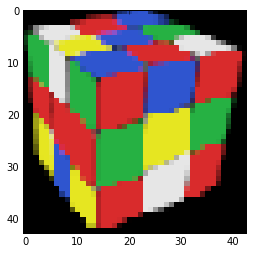

In [87]:
# Evaluate output - each time will be slightly different due to the stochastic pooling
outim = output.eval({l_in.input_var: im})
outim = outim[0]
outim = np.rollaxis(np.rollaxis(outim, 2), 2)
plt.imshow(outim, interpolation='nearest')

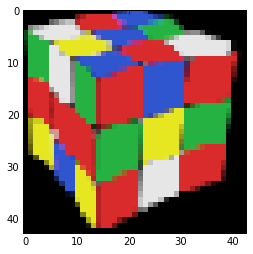

In [88]:
outim = output.eval({l_in.input_var: im})
outim = outim[0]
outim = np.rollaxis(np.rollaxis(outim, 2), 2)
plt.imshow(outim, interpolation='nearest')